## MO444 Project 3 - Reinforcement Learning

* Rodrigo Araújo Marinho Franco - RA: 233569
* Felipe Marinho Tavares - RA: 265680

### Contributions:
* Rodrigo
 * ...
* Felipe
 * ...

# PART I - Evolutionary Model

# PART II - Reinforcement Learning

In [1]:
import sys
sys.path.append("search/")

import torch
import matplotlib.pyplot as plt

import environment

## SmallClassic Environment - Training

Initial state:


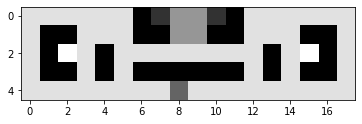

Shape:  (5, 18, 1)
Episode:  1 Average Score: -417.00 Winrate: 0.00%
Episode:  100 Average Score: -350.95 Winrate: 0.00%
Episode:  200 Average Score: -221.28 Winrate: 0.00%
Episode:  300 Average Score: -109.79 Winrate: 9.00%
Episode:  400 Average Score: 25.93 Winrate: 18.00%
Episode:  500 Average Score: 196.21 Winrate: 31.00%
Episode:  600 Average Score: 161.74 Winrate: 30.00%
Episode:  700 Average Score: 281.08 Winrate: 39.00%
Episode:  800 Average Score: 341.15 Winrate: 44.00%
Episode:  900 Average Score: 417.38 Winrate: 47.00%
Episode:  1000 Average Score: 409.99 Winrate: 50.00%
Episode:  1100 Average Score: 358.90 Winrate: 44.00%
Episode:  1200 Average Score: 457.80 Winrate: 52.00%
Episode:  1300 Average Score: 235.95 Winrate: 36.00%
Episode:  1400 Average Score: 271.65 Winrate: 39.00%
Episode:  1500 Average Score: 228.68 Winrate: 35.00%
Episode:  1600 Average Score: 523.24 Winrate: 60.00%
Episode:  1700 Average Score: 344.67 Winrate: 47.00%
Episode:  1800 Average Score: 464.59 Win

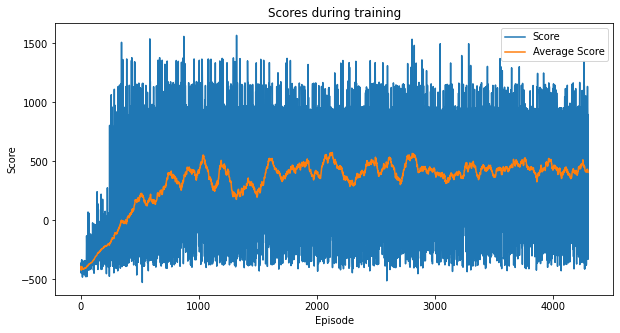

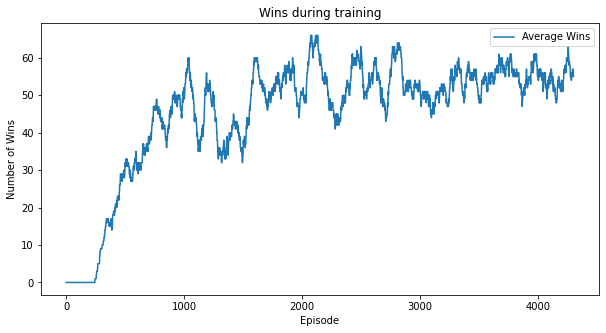

In [2]:
params = {
    "buffer_size": int(5e5),  # replay buffer size
    "batch_size": 32,         # minibatch size
    "gamma": 0.99,            # discount factor
    "tau": 1e-3,              # for soft update of target parameters
    "lr": 2e-3,               # learning rate
    "update_every": 5         # how often to update the network
}

# layouts = smallClassic, mediumClassic, originalClassic
env = environment.Environment(params, layout="smallClassic", use_features=True)

eps_start = 1.0   # Starting exploration rate
#eps_end = 0.05    # Minimun exploration rate (0.05 = 5%)
eps_start = 0.0
eps_end = 0.0
eps_decay=0.999
n_episodes = 10000
print_every = 100 # episodes
patience = 15      # max print_every without improvement tolarated
checkpoints_without_improvement = 0

eps = eps_start
best_score = -1000
for i_episode in range(1, n_episodes + 1):
    env.reset()

    while not env.done():
        env.step(eps)

    eps = max(eps_end, eps_decay*eps)

    env.scores.append(env.game.state.getScore())
    env.scores_window.append(env.game.state.getScore())

    env.wins.append(env.game.state.isWin())
    env.wins_window.append(env.game.state.isWin())

    average_score = sum(env.scores_window)/float(len(env.scores_window))
    winrate = sum(env.wins_window)/float(len(env.wins_window)) * 100.0
    env.average_scores.append(average_score)
    env.average_wins.append(winrate)

    if i_episode == 1 or i_episode % print_every == 0:
        print("Episode: ", i_episode, end=" ")
        print('Average Score: {:.2f}'.format(average_score), end=" ")
        print('Winrate: {:.2f}%'.format(winrate))

        if average_score > best_score:
            checkpoints_without_improvement = 0
            best_score = average_score
            torch.save(env.pacman.qnetwork_local.state_dict(), 'models/checkpoint_small.pth')
        else:
            checkpoints_without_improvement += 1
            if checkpoints_without_improvement == patience:
                print("Stopping training due to lack of improvement")
                break

plt.figure(figsize=(10, 5))
plt.title("Scores during training")
plt.xlabel('Episode')
plt.ylabel('Score')
line1, = plt.plot(env.scores)
line2, = plt.plot(env.average_scores)
plt.legend([line1, line2], ["Score", "Average Score"])
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Wins during training")
plt.xlabel('Episode')
plt.ylabel('Number of Wins')
line1, = plt.plot(env.average_wins)
plt.legend([line1], ["Average Wins"])
plt.show()